<a href="https://colab.research.google.com/github/tatianamgar/Work_GPN/blob/main/NER_BERT_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import random
import pickle


In [ ]:
google_drive_catalog = 'drive/My Drive/EPAM/GZPN-SEAR/20210301/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 def parse_data(file_name):    
     with open(file_name, "r", encoding='utf-8') as f:
         sentence = []
         word = []
         label = []
         sent_num = 0
         n = 0
         for line in f:
             n += 1
             if (line != '\n' and n!=1):
                 line = line.strip()
#                 print(str(n)+' '+line)
                 sentence.append(sent_num)
                 word.append(line.split(' ')[0])
                 label.append(line.split(' _ ')[1])
             else: sent_num += 1

     df = pd.DataFrame()
     df['sentence'] = sentence
     df['word'] = word
     df['label'] = label
     return df

In [ ]:
 data = parse_data(google_drive_catalog+'result.conll')
 data.index = range(len(data))

In [ ]:
data.to_excel(google_drive_catalog+'labels.xlsx')


In [ ]:
def augmentation(data):
  data_new = pd.DataFrame()
  n = data.sentence.max() + 1
  for i in data.sentence.unique():
    data_one_sent = data[data.sentence == i]
    for j in range(3): #для каждого предложения 5 раз аугментация
      try:
        tokens_count = random.randint(2, len(data_one_sent) - 1) #столько токенов мы оставляем в предложении
        tokens_idx = data_one_sent.index
        df_idx = list(random.choices(list(range(tokens_idx.min() + 1, tokens_idx.max())), k = tokens_count)) #индексы случайных токенов, которые остаются
        df_idx.append(tokens_idx.min())
        sent_aug = data_one_sent[data_one_sent.index.isin(df_idx)]
        final_idxs = []
        for idx in sent_aug.index:
          if data_one_sent[data_one_sent.index == idx].label[idx][0] == 'B':
              if (data_one_sent[data_one_sent.index == idx+1].label[idx+1][0] == 'I' and \
                (idx + 1) in list(sent_aug.index)) or \
                data_one_sent[data_one_sent.index == idx+1].label[idx+1][0] != 'I':
                final_idxs.append(idx)
          elif data_one_sent[data_one_sent.index == idx].label[idx][0] == 'I' and \
              data_one_sent[data_one_sent.index == idx-1].label[idx-1][0] == 'B' and (idx - 1) in final_idxs:
              final_idxs.append(idx)
              #print(final_idxs)
              for m in range(1, 6): # максимальное количество токенов в сущности
                #print(idx, m)
                #if data_one_sent.index.max() - data_one_sent.index.min() + m <= len(data_one_sent):
                if idx + m <= data_one_sent.index.max():
                  #print('Еще токены')
                  #print(data_one_sent[data_one_sent.index == idx + m].label[idx + m][0])
                  if data_one_sent[data_one_sent.index == idx + m].label[idx + m][0] == 'I':
                    final_idxs.append(idx + m)
          elif data_one_sent[data_one_sent.index == idx].label[idx][0] == 'O':
            final_idxs.append(idx)
        sent_aug_final = data_one_sent[data_one_sent.index.isin(final_idxs)]
        sent_aug_final['sentence'] = n
#        print(sent_aug_final)
        n += 1
        data_new = pd.concat([data_new, sent_aug_final], axis = 0)
      except:
        0
  return data_new

In [ ]:
data_aug = augmentation(data)

In [ ]:
data_aug.to_excel(google_drive_catalog+'labels_aug.xlsx')

In [ ]:
data = pd.concat([data, data_aug], axis = 0)

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           #s["POS"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[1] for s in sentence] for sentence in getter.sentences]

In [ ]:
tag_values = list(set(data["label"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
with open(google_drive_catalog+'tag_values', 'wb') as fp:
    pickle.dump(tag_values, fp)

In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.7.1+cu101'

In [ ]:
MAX_LEN = 75
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=0, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=0, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.3.3'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 50
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
accuracy_values, validation_accuracy_values = [], []
f1_values, validation_f1_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    y_true, y_pred = [], []
    y_true.append(valid_tags)   
    y_pred.append(pred_tags)                           
    print("Validation Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    validation_accuracy_values.append(accuracy_score(y_true, y_pred))
    print("Validation F1-Score: {}".format(f1_score(y_true, y_pred)))
    validation_f1_values.append(f1_score(y_true, y_pred))
    print()

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Average train loss: 2.9837181170781455
Validation loss: 2.2354490756988525
Validation Accuracy: 0.4520547945205479
Validation F1-Score: 0.0


Epoch:   4%|▍         | 2/50 [00:10<04:20,  5.42s/it]


Average train loss: 2.015206148227056
Validation loss: 1.609904706478119
Validation Accuracy: 0.6604696673189824
Validation F1-Score: 0.5461689587426326

Average train loss: 1.4649626314640045
Validation loss: 1.1384472846984863
Validation Accuracy: 0.7622309197651663
Validation F1-Score: 0.654690618762475


Epoch:   6%|▌         | 3/50 [00:16<04:15,  5.44s/it]

Epoch:   8%|▊         | 4/50 [00:21<04:11,  5.46s/it]

Average train loss: 1.0183278719584148
Validation loss: 0.8577482998371124
Validation Accuracy: 0.8023483365949119
Validation F1-Score: 0.7272727272727272

Average train loss: 0.7187288279334704
Validation loss: 0.6927885413169861
Validation Accuracy: 0.8336594911937377
Validation F1-Score: 0.7524752475247525


Epoch:  10%|█         | 5/50 [00:27<04:06,  5.47s/it]


Average train loss: 0.511382706463337
Validation loss: 0.6065939962863922
Validation Accuracy: 0.8483365949119374


Epoch:  12%|█▏        | 6/50 [00:32<04:02,  5.50s/it]

Validation F1-Score: 0.752895752895753

Average train loss: 0.410918477922678
Validation loss: 0.49430857598781586
Validation Accuracy: 0.8776908023483366
Validation F1-Score: 0.7751937984496124


Epoch:  14%|█▍        | 7/50 [00:38<03:58,  5.55s/it]


Average train loss: 0.3028098853925864


Epoch:  16%|█▌        | 8/50 [00:44<03:55,  5.61s/it]

Validation loss: 0.4607572853565216
Validation Accuracy: 0.9001956947162426
Validation F1-Score: 0.8199233716475096

Average train loss: 0.22917942826946577


Epoch:  18%|█▊        | 9/50 [00:50<03:53,  5.69s/it]

Validation loss: 0.41941599547863007
Validation Accuracy: 0.9090019569471625
Validation F1-Score: 0.8458498023715416

Average train loss: 0.1705380566418171


Epoch:  20%|██        | 10/50 [00:56<03:50,  5.77s/it]

Validation loss: 0.40440063178539276
Validation Accuracy: 0.9129158512720157
Validation F1-Score: 0.8499025341130605

Average train loss: 0.14082424466808638


Epoch:  22%|██▏       | 11/50 [01:02<03:48,  5.85s/it]

Validation loss: 0.43135249614715576
Validation Accuracy: 0.9099804305283757
Validation F1-Score: 0.8460038986354775

Average train loss: 0.11031350928048293


Epoch:  24%|██▍       | 12/50 [01:08<03:44,  5.91s/it]

Validation loss: 0.3859861344099045
Validation Accuracy: 0.9217221135029354
Validation F1-Score: 0.876

Average train loss: 0.09362090689440568


Epoch:  26%|██▌       | 13/50 [01:14<03:39,  5.94s/it]

Validation loss: 0.38146889954805374
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8675623800383876

Average train loss: 0.07169823286434014


Epoch:  28%|██▊       | 14/50 [01:20<03:33,  5.93s/it]

Validation loss: 0.37264473736286163
Validation Accuracy: 0.9227005870841487
Validation F1-Score: 0.8757396449704142

Average train loss: 0.06443796438785891


Epoch:  30%|███       | 15/50 [01:25<03:26,  5.90s/it]

Validation loss: 0.3950889781117439
Validation Accuracy: 0.913894324853229
Validation F1-Score: 0.8637236084452975

Average train loss: 0.0615941317131122


Epoch:  32%|███▏      | 16/50 [01:31<03:19,  5.86s/it]

Validation loss: 0.37840788066387177
Validation Accuracy: 0.9207436399217221
Validation F1-Score: 0.8730769230769231

Average train loss: 0.04994614484409491


Epoch:  34%|███▍      | 17/50 [01:37<03:11,  5.80s/it]

Validation loss: 0.37519627064466476
Validation Accuracy: 0.9197651663405088
Validation F1-Score: 0.8747591522157996

Average train loss: 0.047410715371370316
Validation loss: 0.40102048218250275
Validation Accuracy: 0.913894324853229


Epoch:  36%|███▌      | 18/50 [01:43<03:04,  5.76s/it]

Validation F1-Score: 0.8643410852713179



Epoch:  38%|███▊      | 19/50 [01:48<02:57,  5.72s/it]

Average train loss: 0.03840803603331248
Validation loss: 0.3939066529273987
Validation Accuracy: 0.9207436399217221
Validation F1-Score: 0.8718929254302104

Average train loss: 0.03642030595801771
Validation loss: 0.3929044380784035
Validation Accuracy: 0.9197651663405088


Epoch:  40%|████      | 20/50 [01:54<02:50,  5.69s/it]

Validation F1-Score: 0.8631178707224334

Average train loss: 0.030108265578746796
Validation loss: 0.39608050882816315
Validation Accuracy: 0.9119373776908023


Epoch:  42%|████▏     | 21/50 [01:59<02:44,  5.68s/it]

Validation F1-Score: 0.8576923076923076

Average train loss: 0.028650493128225207


Epoch:  44%|████▍     | 22/50 [02:05<02:39,  5.68s/it]

Validation loss: 0.41044003516435623
Validation Accuracy: 0.9256360078277887
Validation F1-Score: 0.8821292775665398

Average train loss: 0.02723425564666589


Epoch:  46%|████▌     | 23/50 [02:11<02:33,  5.70s/it]

Validation loss: 0.39984485507011414
Validation Accuracy: 0.9197651663405088
Validation F1-Score: 0.8671875

Average train loss: 0.030809310808156926


Epoch:  48%|████▊     | 24/50 [02:17<02:28,  5.73s/it]

Validation loss: 0.41044559329748154
Validation Accuracy: 0.9129158512720157
Validation F1-Score: 0.855513307984791

Average train loss: 0.021246918166677158


Epoch:  50%|█████     | 25/50 [02:22<02:23,  5.74s/it]

Validation loss: 0.41693468391895294
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8665377176015474

Average train loss: 0.020289283866683643


Epoch:  52%|█████▏    | 26/50 [02:28<02:18,  5.76s/it]

Validation loss: 0.41601354628801346
Validation Accuracy: 0.9148727984344422
Validation F1-Score: 0.8653846153846153

Average train loss: 0.01816916310538848


Epoch:  54%|█████▍    | 27/50 [02:34<02:12,  5.77s/it]

Validation loss: 0.4076796770095825
Validation Accuracy: 0.9227005870841487
Validation F1-Score: 0.8742746615087039

Average train loss: 0.019327520160004497


Epoch:  56%|█████▌    | 28/50 [02:40<02:07,  5.78s/it]

Validation loss: 0.4054611474275589
Validation Accuracy: 0.9187866927592955
Validation F1-Score: 0.8699029126213592

Average train loss: 0.01664510656458636


Epoch:  58%|█████▊    | 29/50 [02:46<02:01,  5.77s/it]

Validation loss: 0.4128747582435608
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8670520231213873

Average train loss: 0.017448727041482925


Epoch:  60%|██████    | 30/50 [02:51<01:55,  5.77s/it]

Validation loss: 0.42873603105545044
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8653846153846153

Average train loss: 0.01683239417616278


Epoch:  62%|██████▏   | 31/50 [02:57<01:49,  5.75s/it]

Validation loss: 0.4213443398475647
Validation Accuracy: 0.9187866927592955
Validation F1-Score: 0.8714011516314778

Average train loss: 0.01332845581540217


Epoch:  64%|██████▍   | 32/50 [03:03<01:43,  5.75s/it]

Validation loss: 0.42260923236608505
Validation Accuracy: 0.9148727984344422
Validation F1-Score: 0.8648648648648648

Average train loss: 0.013833114799732963
Validation loss: 0.4285064935684204
Validation Accuracy: 0.9168297455968689


Epoch:  66%|██████▌   | 33/50 [03:09<01:37,  5.74s/it]

Validation F1-Score: 0.8692307692307691

Average train loss: 0.012211008579470217
Validation loss: 0.43302468955516815
Validation Accuracy: 0.9158512720156555


Epoch:  68%|██████▊   | 34/50 [03:14<01:31,  5.73s/it]

Validation F1-Score: 0.8631984585741811

Average train loss: 0.011790967313572764
Validation loss: 0.43934741616249084
Validation Accuracy: 0.913894324853229


Epoch:  70%|███████   | 35/50 [03:20<01:25,  5.72s/it]

Validation F1-Score: 0.859344894026975

Average train loss: 0.012734489282593131
Validation loss: 0.4386356472969055
Validation Accuracy: 0.9148727984344422


Epoch:  72%|███████▏  | 36/50 [03:26<01:19,  5.71s/it]

Validation F1-Score: 0.8615384615384615

Average train loss: 0.011201044777408242


Epoch:  74%|███████▍  | 37/50 [03:31<01:14,  5.72s/it]

Validation loss: 0.4299691617488861
Validation Accuracy: 0.9148727984344422
Validation F1-Score: 0.8648648648648648

Average train loss: 0.01150350629662474


Epoch:  76%|███████▌  | 38/50 [03:37<01:08,  5.72s/it]

Validation loss: 0.4249345362186432
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8648648648648648

Average train loss: 0.011413208829859892


Epoch:  78%|███████▊  | 39/50 [03:43<01:03,  5.73s/it]

Validation loss: 0.4263840317726135
Validation Accuracy: 0.9148727984344422
Validation F1-Score: 0.8648648648648648

Average train loss: 0.010309920568640033


Epoch:  80%|████████  | 40/50 [03:49<00:57,  5.74s/it]

Validation loss: 0.42895273864269257
Validation Accuracy: 0.9148727984344422
Validation F1-Score: 0.8648648648648648

Average train loss: 0.009569854436752697


Epoch:  82%|████████▏ | 41/50 [03:54<00:51,  5.75s/it]

Validation loss: 0.4300525337457657
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8670520231213873

Average train loss: 0.010588027071207762


Epoch:  84%|████████▍ | 42/50 [04:00<00:45,  5.75s/it]

Validation loss: 0.4292833209037781
Validation Accuracy: 0.9158512720156555
Validation F1-Score: 0.8648648648648648

Average train loss: 0.009156392305158079


Epoch:  86%|████████▌ | 43/50 [04:06<00:40,  5.75s/it]

Validation loss: 0.4289998412132263
Validation Accuracy: 0.9178082191780822
Validation F1-Score: 0.8692307692307691

Average train loss: 0.009779168331685165


Epoch:  88%|████████▊ | 44/50 [04:12<00:34,  5.76s/it]

Validation loss: 0.4304615706205368
Validation Accuracy: 0.9178082191780822
Validation F1-Score: 0.8692307692307691

Average train loss: 0.010259179514832795


Epoch:  90%|█████████ | 45/50 [04:17<00:28,  5.77s/it]

Validation loss: 0.43271976709365845
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691

Average train loss: 0.008582569173692415


Epoch:  92%|█████████▏| 46/50 [04:23<00:23,  5.77s/it]

Validation loss: 0.4341742545366287
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691

Average train loss: 0.008497805839094022


Epoch:  94%|█████████▍| 47/50 [04:29<00:17,  5.77s/it]

Validation loss: 0.43337325751781464
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691

Average train loss: 0.008685318093436459


Epoch:  96%|█████████▌| 48/50 [04:35<00:11,  5.76s/it]

Validation loss: 0.4328359365463257
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691

Average train loss: 0.008614491438493133


Epoch:  98%|█████████▊| 49/50 [04:40<00:05,  5.75s/it]

Validation loss: 0.4325871169567108
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691

Average train loss: 0.008705221388178567


Epoch: 100%|██████████| 50/50 [04:46<00:00,  5.73s/it]

Validation loss: 0.4325226843357086
Validation Accuracy: 0.9168297455968689
Validation F1-Score: 0.8692307692307691



In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
model.save_pretrained(google_drive_catalog+'pretrained_model')
tokenizer.save_pretrained(google_drive_catalog+'tokenizer')

In [ ]:
import pickle

with open(google_drive_catalog+'tag_values', 'wb') as fp:
    pickle.dump(tag_values, fp)

In [ ]:
len(tag_values)

61

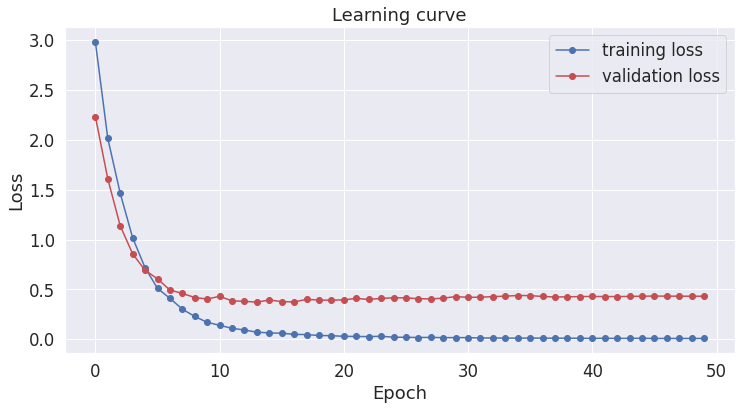

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

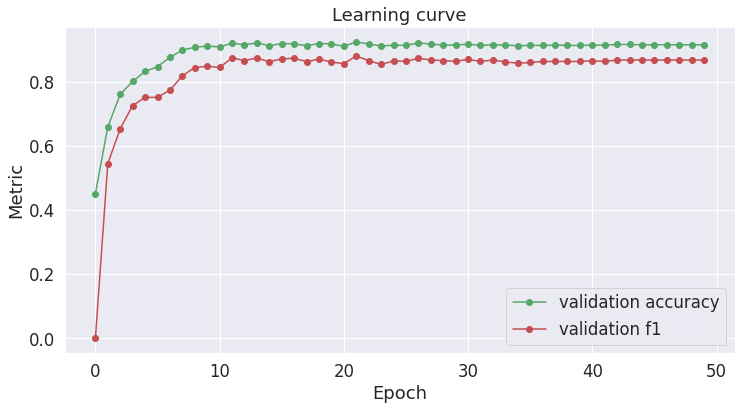

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_accuracy_values, 'g-o', label="validation accuracy")
plt.plot(validation_f1_values, 'r-o', label="validation f1")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

plt.show()

In [ ]:
def make_prediction(test_sentence):
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)  
  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
  
  for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

In [ ]:
test_sentence = """
Кабель контрольный медный, с изоляцией и в оболочке из ПВХ пластиката, огнестойкий, пониженной горючести с низким дымо- и газовыделением, 
с защитным покровом типа БбШв, состоящий из 4 жил сечением 2,5 мм2, КВБбШвнг(А)-FRLS 4х2,5
"""

make_prediction(test_sentence)

In [ ]:
test_sentence = """
Опора желтая 
"""

make_prediction(test_sentence)

In [ ]:
test_sentence = """
Опора 300-ВП-БС2-ВСт3сп4 ОСТ 36-146-88 
"""

make_prediction(test_sentence)

In [ ]:
test_sentence = """
Кабель оптический бронированный стальной гофрированной лентой, оболочка из полиэтилена не распостраняющего горение по категорииВ, н е выделяет коррозионно-активных газообразных продуктов при горении и тлении, 4 оптических модуля по 4 оптичеких волокна, диаметр мод уля 2 мм, центральный силовой элемент-стеклопруток, 16 волокон тип 2, с гидрофобным заполнителем, растягивающее усилие2,7кН ОКЗ-НГ( В)-HF-С-4Сп-16(2)-2,7кН ТУ 3587-002-45869304-98"""

make_prediction(test_sentence)

In [ ]:
test_sentence = """
Кабель оптический, для прокладки в грунт, с центральным оптическим модулем, с оболочкой не распространяющей горение, 24 одномодовых волокна, допустимое растягивающее усилие 7 кН, ОГЦН-24А-7 ТУ 3587-001-58743450-2005
"""

make_prediction(test_sentence)

In [ ]:
test_sentence = """
Кабель оптический, для прокладки в грунт, с центральным оптическим модулем, с оболочкой не распространяющей горение, 24 одномодовых волокна, допустимое растягивающее усилие 7 кН, ОГЦН-24А-7 ТУ 3587-001-58743450-2005
"""

make_prediction(test_sentence)